<a href="https://www.kaggle.com/code/supto137617/commonlit-readability-with-roberta?scriptVersionId=96774080" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Dependencies

In [1]:
import random, os, warnings, math
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
from tensorflow.keras import optimizers, losses, metrics, Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from transformers import TFAutoModelForSequenceClassification, TFAutoModel, AutoTokenizer


def seed_everything(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

seed = 0
seed_everything(seed)
sns.set(style='whitegrid')
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', 150)

### Hardware configuration

In [2]:
# TPU or GPU detection
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print(f'Running on TPU {tpu.master()}')
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

AUTO = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')

REPLICAS: 1


# Load data

In [3]:
train_filepath = '/kaggle/input/commonlitreadabilityprize/train.csv'
test_filepath = '/kaggle/input/commonlitreadabilityprize/test.csv'

train = pd.read_csv(train_filepath)
test = pd.read_csv(test_filepath)

print(f'Train samples: {len(train)}')
display(train.head())

print(f'Test samples: {len(test)}')
display(test.head())

# removing unused columns
train.drop(['url_legal', 'license'], axis=1, inplace=True)
test.drop(['url_legal', 'license'], axis=1, inplace=True)

Train samples: 2834


,id,url_legal,license,excerpt,target,standard_error
0,c12129c31,NaN,NaN,"When the young people returned to the ballroom, it presented a decidedly changed appearance. Instead of an interior scene, it was a winter landsca...",-0.340259,0.464009
1,85aa80a4c,NaN,NaN,"All through dinner time, Mrs. Fayre was somewhat silent, her eyes resting on Dolly with a wistful, uncertain expression. She wanted to give the ch...",-0.315372,0.480805
2,b69ac6792,NaN,NaN,"As Roger had predicted, the snow departed as quickly as it came, and two days after their sleigh ride there was scarcely a vestige of white on the...",-0.580118,0.476676
3,dd1000b26,NaN,NaN,"And outside before the palace a great garden was walled round, filled full of stately fruit-trees, gray olives and sweet figs, and pomegranates, p...",-1.054013,0.450007
4,37c1b32fb,NaN,NaN,"Once upon a time there were Three Bears who lived together in a house of their own in a wood. One of them was a Little, Small, Wee Bear; and one w...",0.247197,0.510845


Test samples: 7


,id,url_legal,license,excerpt
0,c0f722661,NaN,NaN,My hope lay in Jack's promise that he would keep a bright light burning in the upper story to guide me on my course. On a clear night this light w...
1,f0953f0a5,NaN,NaN,"Dotty continued to go to Mrs. Gray's every night with the milk. Sometimes Katie went with her, and then they always paused a while under the acorn..."
2,0df072751,NaN,NaN,It was a bright and cheerful scene that greeted the eyes of Captain Raymond and his son as they entered the parlor of the adjacent cottage.\nIt wa...
3,04caf4e0c,https://en.wikipedia.org/wiki/Cell_division,CC BY-SA 3.0,Cell division is the process by which a parent cell divides into two or more daughter cells. Cell division usually occurs as part of a larger cell...
4,0e63f8bea,https://en.wikipedia.org/wiki/Debugging,CC BY-SA 3.0,Debugging is the process of finding and resolving of defects that prevent correct operation of computer software or a system. Debugging tends to b...


# Model parameters

In [4]:
BATCH_SIZE = 8 * REPLICAS
LEARNING_RATE = 1e-5 * REPLICAS
EPOCHS = 35
ES_PATIENCE = 7
PATIENCE = 2
N_FOLDS = 5
SEQ_LEN = 256 #300
BASE_MODEL = '/kaggle/input/huggingface-roberta/roberta-base/'

## Auxiliary functions

In [5]:
# Datasets utility functions
def custom_standardization(text):
    text = text.lower() # if encoder is uncased
    text = text.strip()
    return text


def sample_target(features, target):
    mean, stddev = target
    sampled_target = tf.random.normal([], mean=tf.cast(mean, dtype=tf.float32), 
                                      stddev=tf.cast(stddev, dtype=tf.float32), dtype=tf.float32)
    
    return (features, sampled_target)
    

def get_dataset(pandas_df, tokenizer, labeled=True, ordered=False, repeated=False, 
                is_sampled=False, batch_size=32, seq_len=128):
    """
        Return a Tensorflow dataset ready for training or inference.
    """
    text = [custom_standardization(text) for text in pandas_df['excerpt']]
    
    # Tokenize inputs
    tokenized_inputs = tokenizer(text, max_length=seq_len, truncation=True, 
                                 padding='max_length', return_tensors='tf')
    
    if labeled:
        dataset = tf.data.Dataset.from_tensor_slices(({'input_ids': tokenized_inputs['input_ids'], 
                                                      'attention_mask': tokenized_inputs['attention_mask']}, 
                                                      (pandas_df['target'], pandas_df['standard_error'])))
        if is_sampled:
            dataset = dataset.map(sample_target, num_parallel_calls=tf.data.AUTOTUNE)
    else:
        dataset = tf.data.Dataset.from_tensor_slices({'input_ids': tokenized_inputs['input_ids'], 
                                                      'attention_mask': tokenized_inputs['attention_mask']})
        
    if repeated:
        dataset = dataset.repeat()
    if not ordered:
        dataset = dataset.shuffle(1024)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    
    return dataset


def plot_metrics(history):
    metric_list = list(history.keys())
    size = len(metric_list)//2
    fig, axes = plt.subplots(size, 1, sharex='col', figsize=(20, size * 5))
    axes = axes.flatten()
    
    for index in range(len(metric_list)//2):
        metric_name = metric_list[index]
        val_metric_name = metric_list[index+size]
        axes[index].plot(history[metric_name], label='Train %s' % metric_name)
        axes[index].plot(history[val_metric_name], label='Validation %s' % metric_name)
        axes[index].legend(loc='best', fontsize=16)
        axes[index].set_title(metric_name)

    plt.xlabel('Epochs', fontsize=16)
    sns.despine()
    plt.show()

# EDA

### Looking at a few examples

In [6]:
display(train.head())

,id,excerpt,target,standard_error
0,c12129c31,"When the young people returned to the ballroom, it presented a decidedly changed appearance. Instead of an interior scene, it was a winter landsca...",-0.340259,0.464009
1,85aa80a4c,"All through dinner time, Mrs. Fayre was somewhat silent, her eyes resting on Dolly with a wistful, uncertain expression. She wanted to give the ch...",-0.315372,0.480805
2,b69ac6792,"As Roger had predicted, the snow departed as quickly as it came, and two days after their sleigh ride there was scarcely a vestige of white on the...",-0.580118,0.476676
3,dd1000b26,"And outside before the palace a great garden was walled round, filled full of stately fruit-trees, gray olives and sweet figs, and pomegranates, p...",-1.054013,0.450007
4,37c1b32fb,"Once upon a time there were Three Bears who lived together in a house of their own in a wood. One of them was a Little, Small, Wee Bear; and one w...",0.247197,0.510845


### Now the examples with the 5 lowest `target` values

In [7]:
display(train.sort_values(by=['target']).head())

,id,excerpt,target,standard_error
1705,4626100d8,"The commutator is peculiar, consisting of only three segments of a copper ring, while in the simplest of other continuous current generators sever...",-3.676268,0.623621
1128,493b80aa7,"The Dunwich horror itself came between Lammas and the equinox in 1928, and Dr. Armitage was among those who witnessed its monstrous prologue. He h...",-3.668360,0.571404
1754,fe44cbd14,"The iron cylinder weighs 23 kilogrammes; but, when the current has an intensity of 43 amperes and traverses 15 sections, the stress developed may ...",-3.642892,0.644398
1752,284eaa5ad,As to surface-slope its measurement—from nearly 600 trials—was found to be such a delicate operation that the result would be of doubtful utility....,-3.639936,0.603819
1720,9e9eacb49,"The tree is dioecious, bearing male catkins on one plant, female on another. All the female trees in Europe are believed to have originated from a...",-3.636834,0.606822


### Now the examples with the 5 highest `target` values

In [8]:
display(train.sort_values(by=['target'], ascending=False).head())

,id,excerpt,target,standard_error
2829,25ca8f498,"When you think of dinosaurs and where they lived, what do you picture? Do you see hot, steamy swamps, thick jungles, or sunny plains? Dinosaurs li...",1.711390,0.646900
981,849971671,"For her last birthday, Sisanda had a special treat – her parents got permission for her to have a party at the game reserve. The giraffes at the r...",1.597870,0.596349
808,8f35441e3,"Every day, Emeka's father took him to school in his car. He also brought Emeka home after school. One afternoon on their way home, Emeka's father ...",1.583847,0.624776
1014,7a1d484be,"More people came to the bus stop just before 9am. Half an hour later they are all still waiting. Sam is worried. ""Maybe the bus broke down,"" he th...",1.541672,0.606997
1066,016913371,"Grandma's garden was wonderful. It was full of sorghum, millet, and cassava. But best of all were the bananas. Although Grandma had many grandchil...",1.467665,0.599600


I would say that just by simply looking at those samples may be a little hard to decide the `target` score for them, but the samples with the lowest `target` score seems to have a mixture of grammatical, semantics, and punctuation error, that indeed would make them less easy to reading and understanding.

## Label distribution

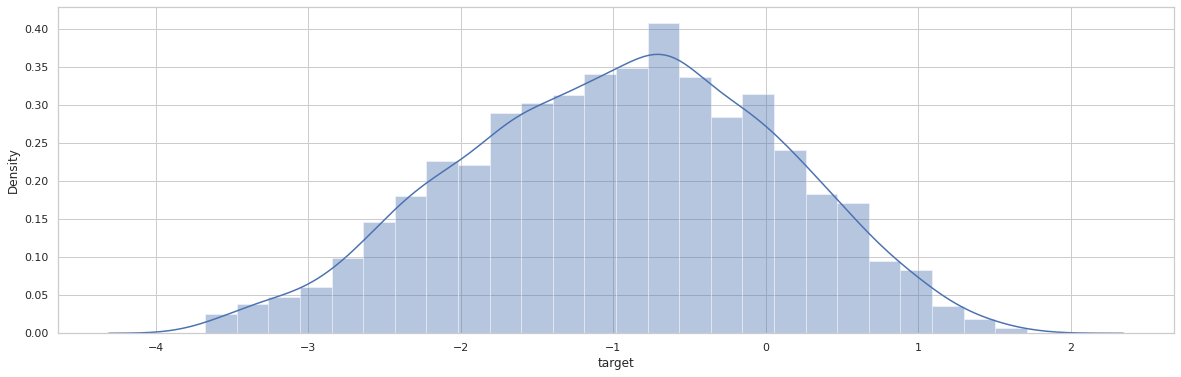

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(20, 6))
sns.distplot(train['target'], ax=ax)
plt.show()

The `target` column follows a distribution close to normal, but we can see that we have much more samples with the negative score than positive, also the negative values get close to `-4` while positive only go as high as `2`.

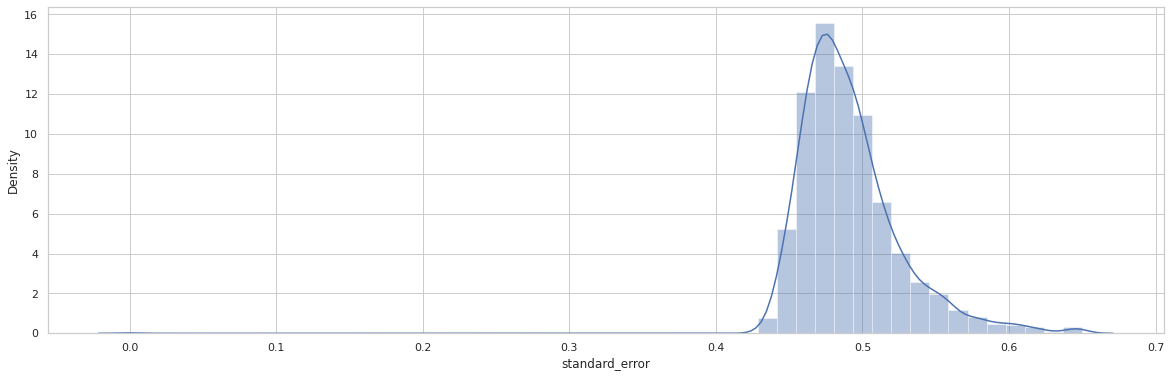

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(20, 6))
sns.distplot(train['standard_error'], ax=ax)
plt.show()

The `standard_error` column seems to have some outliers with values lower than `0.4`.

In [11]:
print(f"standard_error values >= than 0.4: {len(train[train['standard_error'] >= 0.4])}")
print(f"standard_error values < than 0.4: {len(train[train['standard_error'] < 0.4])}")

standard_error values >= than 0.4: 2833
standard_error values < than 0.4: 1


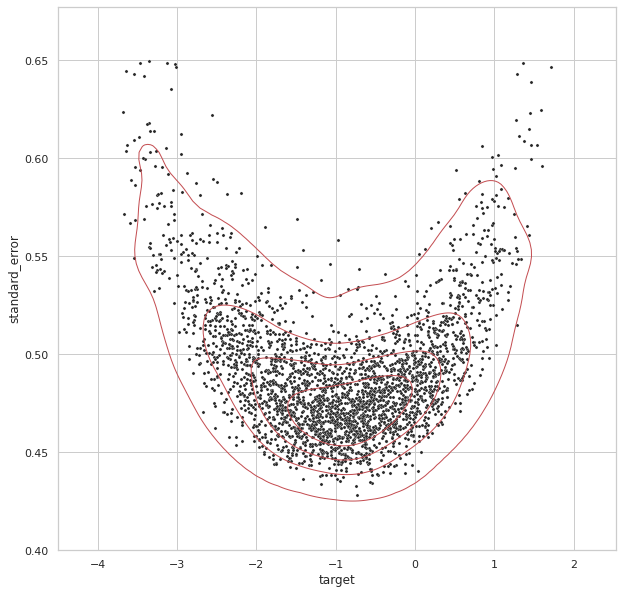

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.scatterplot(x=train['target'], y=train['standard_error'], s=10, color=".15")
sns.kdeplot(x=train['target'], y=train['standard_error'], levels=5, color="r", linewidths=1)
plt.ylim([0.4, None])
plt.show()

We can see that samples with extreme `target` values (closer to `-4` and `2`) usually have higher `standard_error`.

## `excerpt` text distribution

### `excerpt` length

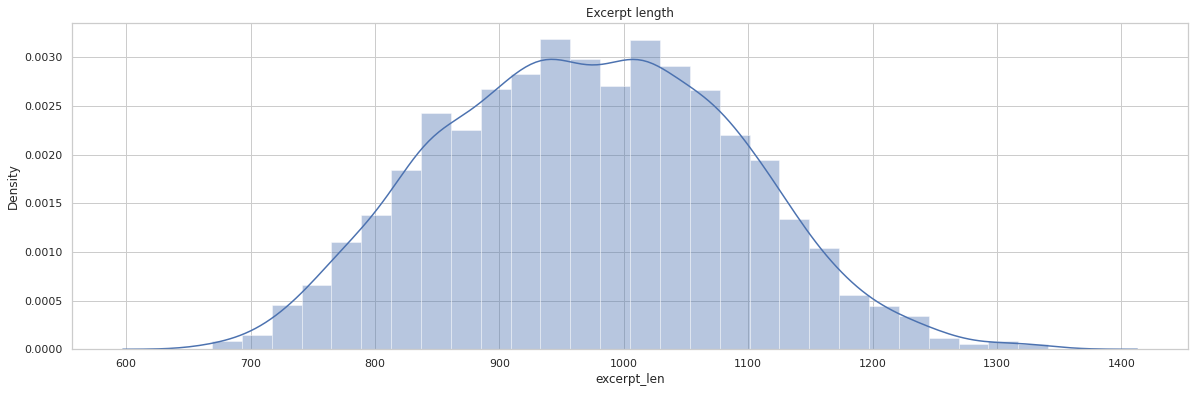

In [13]:
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL)
train['excerpt_len'] = train['excerpt'].apply(lambda x : len(x))
train['excerpt_wordCnt'] = train['excerpt'].apply(lambda x : len(x.split(' ')))
train['excerpt_tokenCnt'] = train['excerpt'].apply(lambda x : len(tokenizer.encode(x, add_special_tokens=False)))

fig, ax = plt.subplots(1, 1, figsize=(20, 6))
sns.distplot(train['excerpt_len'], ax=ax).set_title('Excerpt length')
plt.show()

### `excerpt` word count

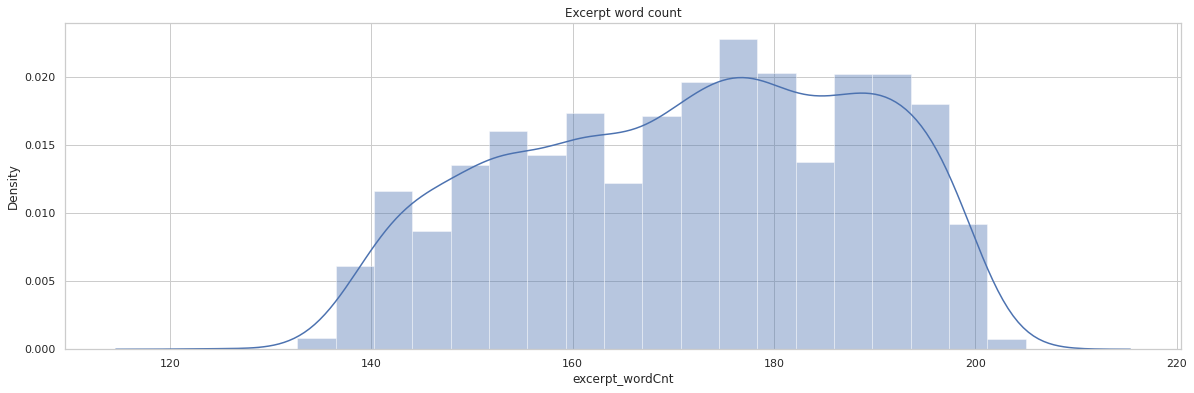

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(20, 6))
sns.distplot(train['excerpt_wordCnt'], ax=ax).set_title('Excerpt word count')
plt.show()

### `excerpt` token count (after using the tokenizer)

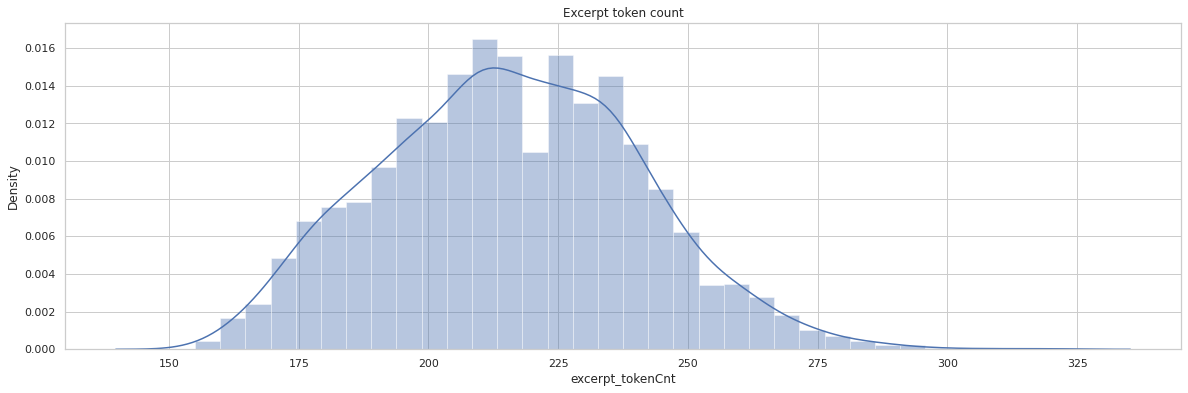

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(20, 6))
sns.distplot(train['excerpt_tokenCnt'], ax=ax).set_title('Excerpt token count')
plt.show()

# Model

In [16]:
def model_fn(encoder, seq_len=256):
    input_ids = L.Input(shape=(seq_len,), dtype=tf.int32, name='input_ids')
    input_attention_mask = L.Input(shape=(seq_len,), dtype=tf.int32, name='attention_mask')
    
    outputs = encoder({'input_ids': input_ids, 
                       'attention_mask': input_attention_mask})
    
    model = Model(inputs=[input_ids, input_attention_mask], outputs=outputs)

    optimizer = optimizers.Adam(lr=LEARNING_RATE)
    model.compile(optimizer=optimizer, 
                  loss=losses.MeanSquaredError(), 
                  metrics=[metrics.RootMeanSquaredError()])
    
    return model


with strategy.scope():
    encoder = TFAutoModelForSequenceClassification.from_pretrained(BASE_MODEL, num_labels=1)
    model = model_fn(encoder, SEQ_LEN)
    
model.summary()

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at /kaggle/input/huggingface-roberta/roberta-base/ and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
attention_mask (InputLayer)     [(None, 256)]        0                                            
__________________________________________________________________________________________________
input_ids (InputLayer)          [(None, 256)]        0                                            
__________________________________________________________________________________________________
tf_roberta_for_sequence_classif TFSequenceClassifier 124646401   attention_mask[0][0]             
                                                                 input_ids[0][0]                  
Total params: 124,646,401
Trainable params: 124,646,401
Non-trainable params: 0
__________________________________________________________________________________________________


# Training

In [17]:
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL)
skf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=seed)
oof_pred = []; oof_labels = []; history_list = []; test_pred = []

for fold,(idxT, idxV) in enumerate(skf.split(train)):
    if tpu: tf.tpu.experimental.initialize_tpu_system(tpu)
    print(f'\nFOLD: {fold+1}')
    print(f'TRAIN: {len(idxT)} VALID: {len(idxV)}')

    # Model
    K.clear_session()
    with strategy.scope():
        encoder = TFAutoModelForSequenceClassification.from_pretrained(BASE_MODEL, num_labels=1)
        model = model_fn(encoder, SEQ_LEN)
        
    model_path = f'model_{fold}.h5'
    es = EarlyStopping(monitor='val_root_mean_squared_error', mode='min', 
                       patience=ES_PATIENCE, restore_best_weights=True, verbose=1)
    checkpoint = ModelCheckpoint(model_path, monitor='val_root_mean_squared_error', mode='min', 
                                 save_best_only=True, save_weights_only=True)

    # Train
    history = model.fit(x=get_dataset(train.loc[idxT], tokenizer, repeated=True, is_sampled=True, 
                                      batch_size=BATCH_SIZE, seq_len=SEQ_LEN), 
                        validation_data=get_dataset(train.loc[idxV], tokenizer, ordered=True, 
                                                    batch_size=BATCH_SIZE, seq_len=SEQ_LEN), 
                        steps_per_epoch=50, 
                        callbacks=[es, checkpoint], 
                        epochs=EPOCHS,  
                        verbose=2).history
      
    history_list.append(history)
    # Save last model weights
    model.load_weights(model_path)
    
    # Results
    print(f"#### FOLD {fold+1} OOF RMSE = {np.min(history['val_root_mean_squared_error']):.4f}")

    # OOF predictions
    valid_ds = get_dataset(train.loc[idxV], tokenizer, ordered=True, batch_size=BATCH_SIZE, seq_len=SEQ_LEN)
    oof_labels.append([target[0].numpy() for sample, target in iter(valid_ds.unbatch())])
    x_oof = valid_ds.map(lambda sample, target: sample)
    oof_pred.append(model.predict(x_oof)['logits'])

    # Test predictions
    test_ds = get_dataset(test, tokenizer, labeled=False, ordered=True, batch_size=BATCH_SIZE, seq_len=SEQ_LEN)
    x_test = test_ds.map(lambda sample: sample)
    test_pred.append(model.predict(x_test)['logits'])


FOLD: 1
TRAIN: 2267 VALID: 567


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at /kaggle/input/huggingface-roberta/roberta-base/ and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/35
50/50 - 40s - loss: 1.3835 - root_mean_squared_error: 1.1762 - val_loss: 0.8699 - val_root_mean_squared_error: 0.9327
Epoch 2/35
50/50 - 21s - loss: 0.9598 - root_mean_squared_error: 0.9797 - val_loss: 0.4925 - val_root_mean_squared_error: 0.7018
Epoch 3/35
50/50 - 21s - loss: 0.6945 - root_mean_squared_error: 0.8334 - val_loss: 0.4073 - val_root_mean_squared_error: 0.6382
Epoch 4/35
50/50 - 21s - loss: 0.6451 - root_mean_squared_error: 0.8032 - val_loss: 0.7582 - val_root_mean_squared_error: 0.8707
Epoch 5/35
50/50 - 20s - loss: 0.6789 - root_mean_squared_error: 0.8240 - val_loss: 0.3841 - val_root_mean_squared_error: 0.6198
Epoch 6/35
50/50 - 20s - loss: 0.5425 - root_mean_squared_error: 0.7365 - val_loss: 0.3608 - val_root_mean_squared_error: 0.6006
Epoch 7/35
50/50 - 20s - loss: 0.6508 - root_mean_squared_error: 0.8067 - val_loss: 0.3345 - val_root_mean_squared_error: 0.5784
Epoch 8/35
50/50 - 20s - loss: 0.5225 - root_mean_squared_error: 0.7228 - val_loss: 0.3476 - val_

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at /kaggle/input/huggingface-roberta/roberta-base/ and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/35
50/50 - 39s - loss: 1.2251 - root_mean_squared_error: 1.1068 - val_loss: 0.7599 - val_root_mean_squared_error: 0.8717
Epoch 2/35
50/50 - 21s - loss: 0.9361 - root_mean_squared_error: 0.9675 - val_loss: 0.6135 - val_root_mean_squared_error: 0.7833
Epoch 3/35
50/50 - 20s - loss: 0.8631 - root_mean_squared_error: 0.9290 - val_loss: 0.4123 - val_root_mean_squared_error: 0.6421
Epoch 4/35
50/50 - 21s - loss: 0.7635 - root_mean_squared_error: 0.8738 - val_loss: 0.7445 - val_root_mean_squared_error: 0.8628
Epoch 5/35
50/50 - 20s - loss: 0.5819 - root_mean_squared_error: 0.7628 - val_loss: 0.4381 - val_root_mean_squared_error: 0.6619
Epoch 6/35
50/50 - 20s - loss: 0.6983 - root_mean_squared_error: 0.8356 - val_loss: 0.4087 - val_root_mean_squared_error: 0.6393
Epoch 7/35
50/50 - 21s - loss: 0.6322 - root_mean_squared_error: 0.7951 - val_loss: 0.5222 - val_root_mean_squared_error: 0.7227
Epoch 8/35
50/50 - 20s - loss: 0.5734 - root_mean_squared_error: 0.7572 - val_loss: 0.4222 - val_

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at /kaggle/input/huggingface-roberta/roberta-base/ and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/35
50/50 - 40s - loss: 1.3469 - root_mean_squared_error: 1.1605 - val_loss: 0.7425 - val_root_mean_squared_error: 0.8617
Epoch 2/35
50/50 - 20s - loss: 0.9730 - root_mean_squared_error: 0.9864 - val_loss: 0.7635 - val_root_mean_squared_error: 0.8738
Epoch 3/35
50/50 - 20s - loss: 0.8458 - root_mean_squared_error: 0.9197 - val_loss: 0.4379 - val_root_mean_squared_error: 0.6617
Epoch 4/35
50/50 - 20s - loss: 0.6681 - root_mean_squared_error: 0.8174 - val_loss: 0.4723 - val_root_mean_squared_error: 0.6872
Epoch 5/35
50/50 - 20s - loss: 0.6202 - root_mean_squared_error: 0.7875 - val_loss: 0.4741 - val_root_mean_squared_error: 0.6885
Epoch 6/35
50/50 - 20s - loss: 0.5986 - root_mean_squared_error: 0.7737 - val_loss: 0.3680 - val_root_mean_squared_error: 0.6066
Epoch 7/35
50/50 - 20s - loss: 0.5710 - root_mean_squared_error: 0.7556 - val_loss: 0.3770 - val_root_mean_squared_error: 0.6140
Epoch 8/35
50/50 - 20s - loss: 0.5963 - root_mean_squared_error: 0.7722 - val_loss: 0.4134 - val_

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at /kaggle/input/huggingface-roberta/roberta-base/ and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/35
50/50 - 38s - loss: 1.2941 - root_mean_squared_error: 1.1376 - val_loss: 0.7541 - val_root_mean_squared_error: 0.8684
Epoch 2/35
50/50 - 21s - loss: 0.8217 - root_mean_squared_error: 0.9065 - val_loss: 0.4076 - val_root_mean_squared_error: 0.6385
Epoch 3/35
50/50 - 20s - loss: 0.6607 - root_mean_squared_error: 0.8128 - val_loss: 0.8057 - val_root_mean_squared_error: 0.8976
Epoch 4/35
50/50 - 20s - loss: 0.6728 - root_mean_squared_error: 0.8203 - val_loss: 0.4075 - val_root_mean_squared_error: 0.6384
Epoch 5/35
50/50 - 20s - loss: 0.6169 - root_mean_squared_error: 0.7854 - val_loss: 0.6744 - val_root_mean_squared_error: 0.8212
Epoch 6/35
50/50 - 20s - loss: 0.6348 - root_mean_squared_error: 0.7967 - val_loss: 0.4662 - val_root_mean_squared_error: 0.6828
Epoch 7/35
50/50 - 20s - loss: 0.5309 - root_mean_squared_error: 0.7286 - val_loss: 0.3394 - val_root_mean_squared_error: 0.5826
Epoch 8/35
50/50 - 20s - loss: 0.5215 - root_mean_squared_error: 0.7221 - val_loss: 0.3636 - val_

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at /kaggle/input/huggingface-roberta/roberta-base/ and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/35
50/50 - 39s - loss: 1.4252 - root_mean_squared_error: 1.1938 - val_loss: 0.7769 - val_root_mean_squared_error: 0.8814
Epoch 2/35
50/50 - 20s - loss: 1.0856 - root_mean_squared_error: 1.0419 - val_loss: 0.5730 - val_root_mean_squared_error: 0.7569
Epoch 3/35
50/50 - 20s - loss: 0.8776 - root_mean_squared_error: 0.9368 - val_loss: 0.4238 - val_root_mean_squared_error: 0.6510
Epoch 4/35
50/50 - 20s - loss: 0.7990 - root_mean_squared_error: 0.8939 - val_loss: 0.3939 - val_root_mean_squared_error: 0.6276
Epoch 5/35
50/50 - 20s - loss: 0.6869 - root_mean_squared_error: 0.8288 - val_loss: 0.4043 - val_root_mean_squared_error: 0.6359
Epoch 6/35
50/50 - 20s - loss: 0.5720 - root_mean_squared_error: 0.7563 - val_loss: 0.3436 - val_root_mean_squared_error: 0.5861
Epoch 7/35
50/50 - 20s - loss: 0.6446 - root_mean_squared_error: 0.8029 - val_loss: 0.3477 - val_root_mean_squared_error: 0.5897
Epoch 8/35
50/50 - 20s - loss: 0.5815 - root_mean_squared_error: 0.7625 - val_loss: 0.3415 - val_

## Model loss and metrics graph


FOLD: 1


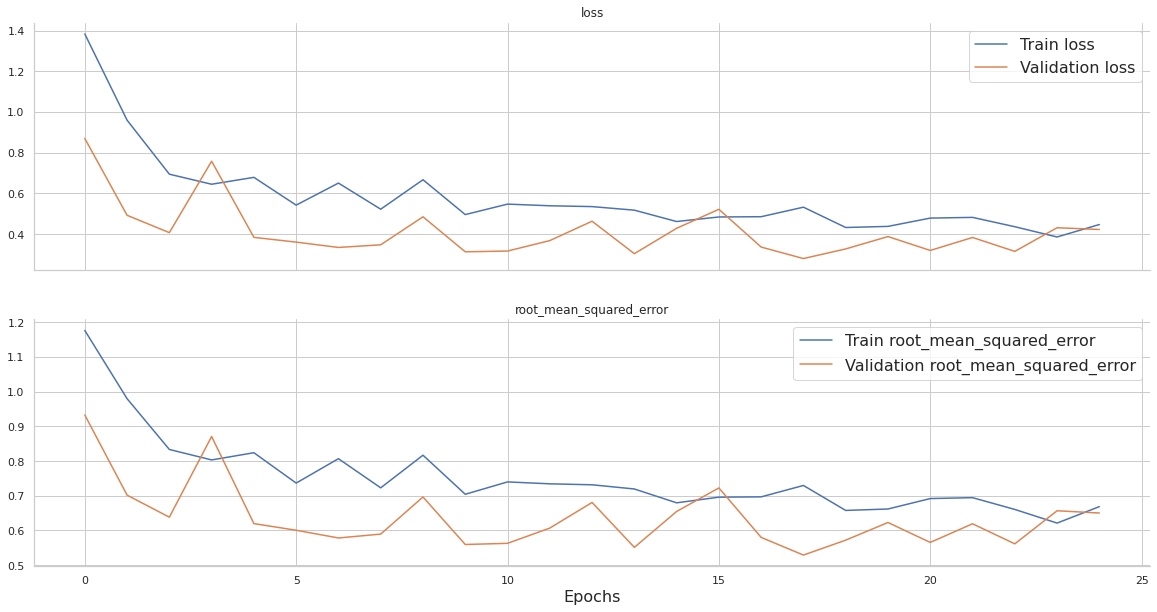


FOLD: 2


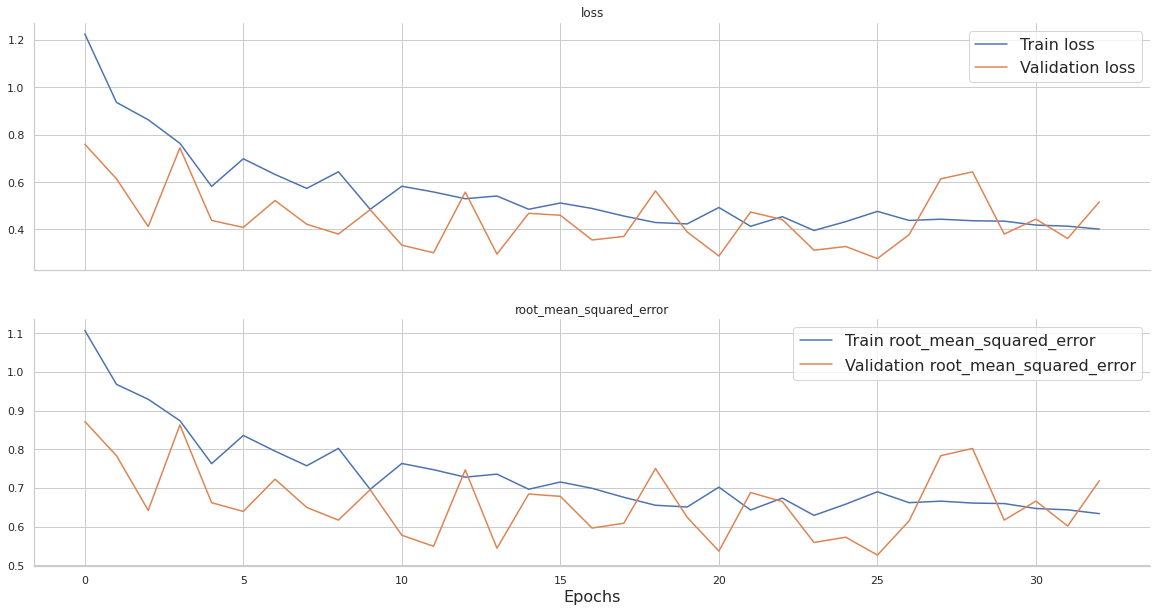


FOLD: 3


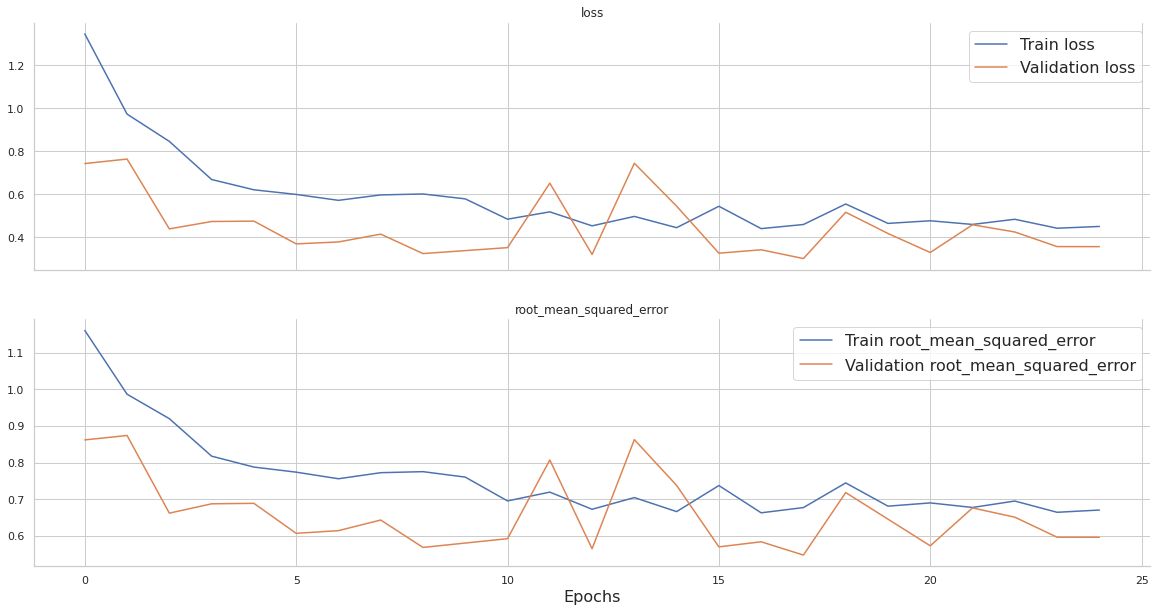


FOLD: 4


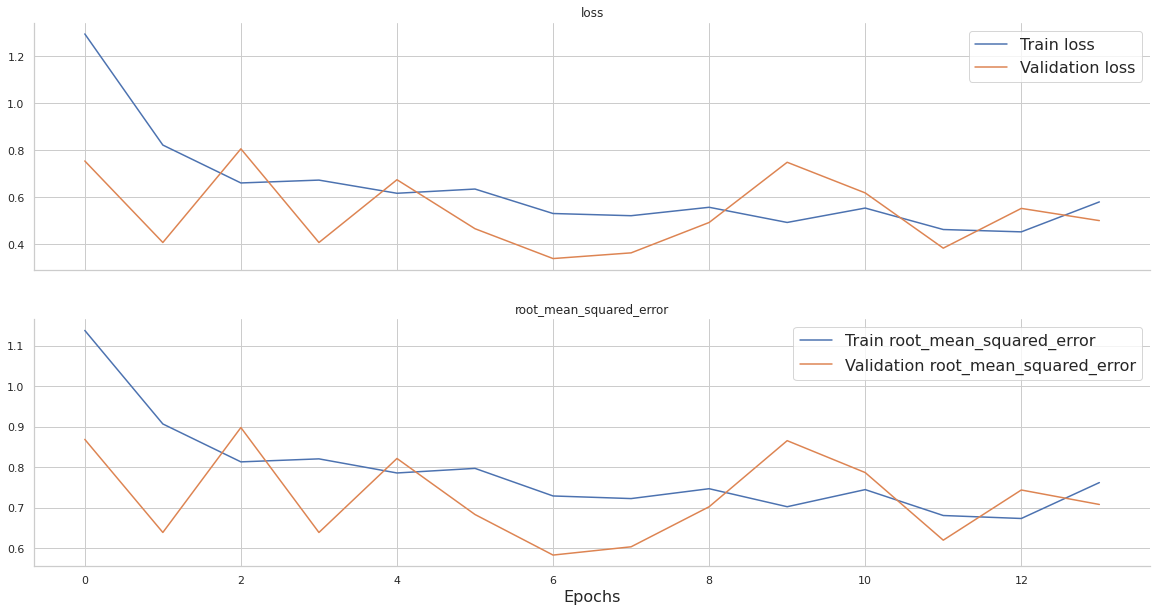


FOLD: 5


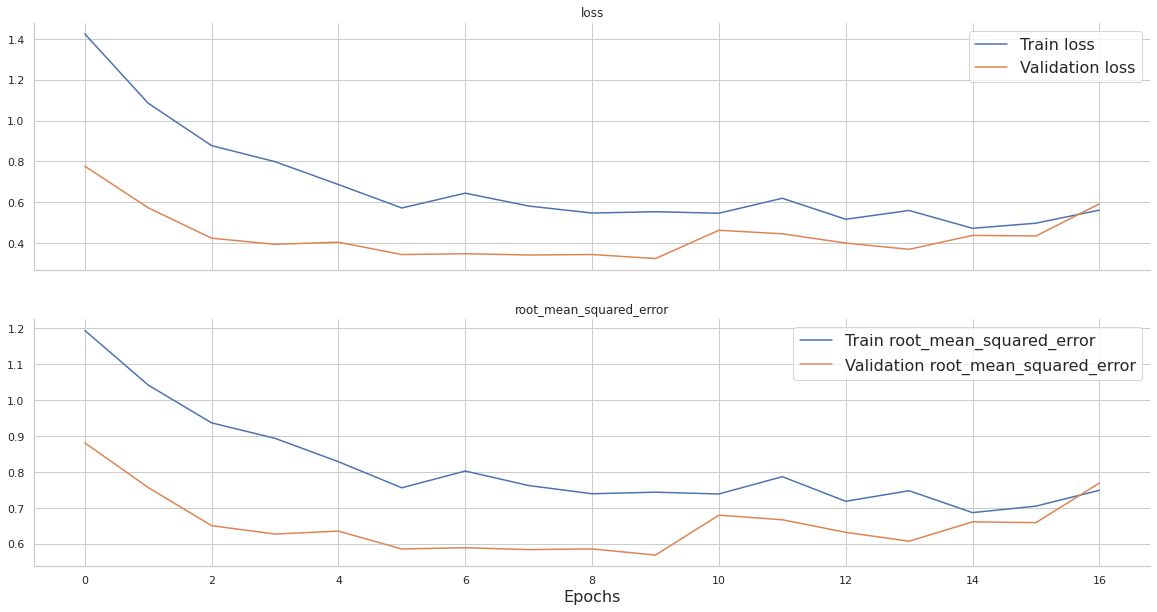

In [18]:
for fold, history in enumerate(history_list):
    print(f'\nFOLD: {fold+1}')
    plot_metrics(history)

# Model evaluation

We are evaluating the model on the `OOF` predictions, it stands for `Out Of Fold`, since we are training using `K-Fold` our model will see all the data, and the correct way to evaluate each fold is by looking at the predictions that are not from that fold.

## OOF metrics

In [19]:
y_true = np.concatenate(oof_labels)
y_preds = np.concatenate(oof_pred)


for fold, history in enumerate(history_list):
    print(f"FOLD {fold+1} RMSE: {np.min(history['val_root_mean_squared_error']):.4f}")
    
print(f'OOF RMSE: {mean_squared_error(y_true, y_preds, squared=False):.4f}')

FOLD 1 RMSE: 0.5291
FOLD 2 RMSE: 0.5267
FOLD 3 RMSE: 0.5473
FOLD 4 RMSE: 0.5826
FOLD 5 RMSE: 0.5692
OOF RMSE: 0.5514


### **Error analysis**, label x prediction distribution

Here we can compare the distribution from the labels and the predicted values, in a perfect scenario they should align.

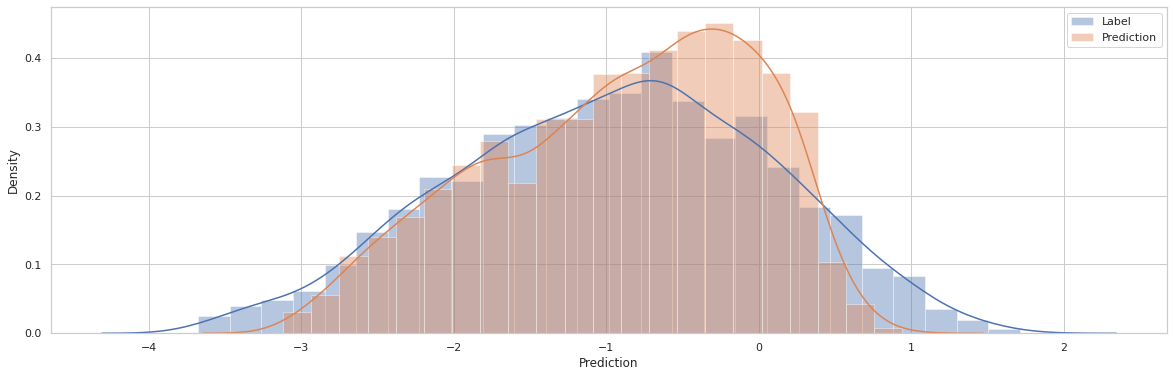

In [20]:
preds_df = pd.DataFrame({'Label': y_true, 'Prediction': y_preds[:,0]})

fig, ax = plt.subplots(1, 1, figsize=(20, 6))
sns.distplot(preds_df['Label'], ax=ax, label='Label')
sns.distplot(preds_df['Prediction'], ax=ax, label='Prediction')
ax.legend()
plt.show()

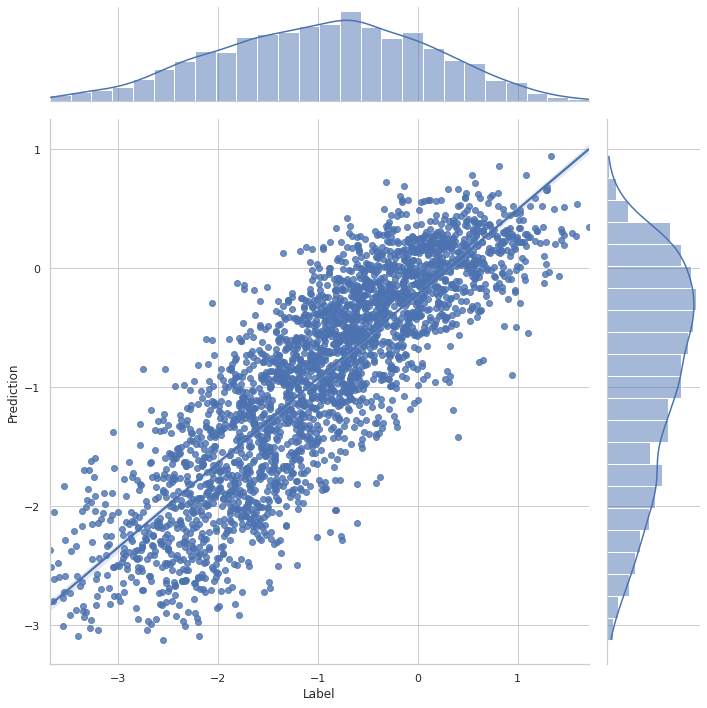

In [21]:
sns.jointplot(data=preds_df, x='Label', y='Prediction', kind='reg', height=10)
plt.show()

# Test set predictions

In [22]:
submission = test[['id']]
submission['target'] = np.mean(test_pred, axis=0)
submission.to_csv('submission.csv', index=False)
display(submission.head(10))

,id,target
0,c0f722661,-0.469780
1,f0953f0a5,-0.359086
2,0df072751,-0.315507
3,04caf4e0c,-2.458598
4,0e63f8bea,-1.708265
5,12537fe78,-1.289125
6,965e592c0,0.376091
